In [114]:
import numpy as np
import scipy as sp
import sympy as sm
from scipy import linalg
from scipy import optimize
from scipy import interpolate

%matplotlib inline
import matplotlib.pyplot as plt # baseline modul
from mpl_toolkits.mplot3d import Axes3D # for 3d figures
plt.style.use('seaborn-whitegrid') # whitegrid nice with 3d

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [3]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [4]:
N = 10000
np.random.seed(2020)
x1,x2,y = DGP(N)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}

## answer to question 1.1:

In [5]:
#creating an array to turn into X
X = np.arange(N*3).reshape(N,3) # 10,000 lists 3 objects in each list.
X = X.astype(np.float32) # converting to floats.

In [6]:
# assigning the values 1, x1, and x2 to element 0, 1, and 2 in each list of the array.
for i in range(N):
    X[i-1][0] = 1
    X[i-1][1] = x1[i-1]
    X[i-1][2] = x2[i-1]

# creating an array containing 1 list of y values.
y = np.array(y)

# generating variable for transposed X
XT = X.T

# generating the inverse of XT times X
# first XT times X
XTX = XT@X
# then inverse it
XTXI = linalg.inv(XTX)

In [7]:
# checking everything looks correct
print('X02', X[0][2])
print('X', X[0:2])
print('y', y)
print('XT', XT)
print('XTX', XTX, XTX.shape) #must be a 3x3 matrix
print('XTXI', XTXI, XTXI.shape) # also a 3x3 matrix
print('Inverse times normal', XTXI@XTX) # might not be equal to identity matrix, but that's just how it is working with floats.

X02 -0.18279442
X [[ 1.         -1.7688457  -0.18279442]
 [ 1.          0.07555227  0.7806237 ]]
y [-1.06458366  0.58562919 -0.91755295 ... -6.98529298  0.08526139
  0.70458339]
XT [[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [-1.7688457   0.07555227 -1.1306297  ...  0.0370484   1.7089268
   2.0612805 ]
 [-0.18279442  0.7806237  -1.0122054  ... -1.4428681  -0.10668644
   0.55908185]]
XTX [[10000.         113.945404  -122.56512 ]
 [  113.945404  9798.045       11.282481]
 [ -122.56512     11.282481  9775.233   ]] (3, 3)
XTXI [[ 1.0002866e-04 -1.1647193e-06  1.2555367e-06]
 [-1.1647193e-06  1.0207488e-04 -1.3241750e-07]
 [ 1.2555369e-06 -1.3241750e-07  1.0231524e-04]] (3, 3)
Inverse times normal [[ 1.00000000e+00  1.53351026e-10 -6.76679379e-10]
 [ 5.38862288e-10  1.00000000e+00 -1.07974227e-10]
 [ 1.01056274e-10 -9.61029312e-11  1.00000000e+00]]


Now that we have all the elements of $\hat{\beta}$ we can calculate it

In [64]:
# generating betahat
b = XTXI@XT@y
# generating a variable for each beta for later use.
b0 = b[0]
b1 = b[1]
b2 = b[2]
b

array([0.0956821 , 0.29294298, 0.50332769])

We find that:  
$\hat{\beta}_0 = 0.096$  
$\hat{\beta}_1 = 0.29$  
$\hat{\beta}_2 = 0.50$

**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

## Answer to question 1.2

We want to construct a 3d plot, to do this we first need to define $\hat{y}_i$  
We alrady have the data from question 1.1

In [9]:
#Defining yhat
def yfunc(x1,x2):
    return b0 + b1*x1 + b2*x2

In [10]:
# creating x grid for plotting
x1_values, x2_values = np.meshgrid(np.linspace(min(x1),max(x1),100),np.linspace(min(x1),max(x1),100)) # We are using 100 x values instead of the given x1 and x2 as all 10000 observations will crash the kernel, we can't seem to figure out why.
y_values = yfunc(x1_values,x2_values) # find yhat values from func.

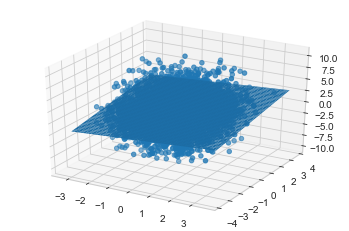

In [11]:
fig12 = plt.figure() # create the figure
ax = fig12.add_subplot(111,projection='3d') # create a 3d axis in the figure 
ax.scatter3D(x1,x2,y) # create scatterplot
ax.plot_surface(x1_values, x2_values, y_values); # create plane

We have plotted the randomly given data as a scatterplot.  
We had to use linspace of 100 values for $\hat{y}_i$, beacuase otherwise it would crash.

## **Question 3:** 
Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

### Answer to question 1.3:

In [78]:
#Defining the solver
beta_solve = (0,1,2)
def solve_OLS(beta_solve, y, x1, x2):
    # define objective function
    def obj(beta_solve):
        b0 = beta_solve[0] # defining each element in the tuble as variable so it looks cleaner in the return function.
        b1 = beta_solve[1]
        b2 = beta_solve[2]
        return np.sum((y - (b0 + b1*x1 + b2*x2))**2) # the funtion displayed above.

    result = optimize.minimize(obj,(0.5,0.5,0.5), method='nelder-mead') # solve the obj function
    return result

In [91]:
solved_beta = solve_OLS(beta_solve, y, x1, x2)
print(solved_beta.x)
# assigning values for later use.
solved_b0 = solved_beta.x[0]
solved_b1 = solved_beta.x[1]
solved_b2 = solved_beta.x[2]

[0.09565114 0.29293949 0.50329556]


By using the solver we find the followng values of $\beta$:  
$\hat{\beta}_0 = 0.096$  
$\hat{\beta}_1 = 0.29$  
$\hat{\beta}_2 = 0.50$

In [110]:
#Comparing the results with the matrix algebra
diff_beta = solved_beta.x - b
print(f"Difference between the two beta 0s = {diff_beta[0]:.6f}")
print(f"Difference between the two beta 1s = {diff_beta[1]:.6f}")
print(f"Difference between the two beta 2s = {diff_beta[2]:.6f}")

Difference between the two beta 0s = -0.000031
Difference between the two beta 1s = -0.000003
Difference between the two beta 2s = -0.000032


We see that in all 3 cases the beta found in the matrix algebra is a tiny bit larger than the one from the solver.

## **Question 4:** 
Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

### Answer to question 1.4

We need to define the hessian matrix for the numerical solver.  
The we can use the Newton optimizer from scipy together with the hessian.

In [116]:
# defining the problem
def LAD(b, y, x1, x2):
    b0 = b[0]
    b1 = b[1]
    b2 = b[2]
    return sum(abs(y-(b0 + b1*x1 + b2*x2)))

# differentiating the function for the hessian

LAD_hess

**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [4]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [5]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

**Optimizer function:**

In [6]:
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10_000):
    pass

**Test case:**

In [7]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

not implemented yet
